In [1]:
import jupyter_black

jupyter_black.load()

In [2]:
from qlearning import QLearner
from grid_world import PickUpAndDeliver
import pandas as pd
import numpy as np

In [3]:
def reward(current_state, previous_state):
    position, damage, pickup = current_state
    _, previous_damage, _ = previous_state

    if damage == 5:
        return np.array([-25, -25])
    if position == 22 and pickup == True:
        return np.array([50, 50])
    if previous_damage < damage:
        return np.array([-1, -10])
    else:
        return np.array([-1, 0])


def update_state(state, actor_pos):
    terminal = False
    _, damage, pickup = state
    damage_pos = [0, 1, 11, 12, 16, 18, 23, 25, 30, 36, 39]
    if actor_pos in damage_pos:
        damage += 1
    if actor_pos == 19:
        pickup = True
    if (actor_pos == 22 and pickup) or damage == 5:
        terminal = True
    return (actor_pos, damage, pickup), terminal


def env():
    height = 6
    width = 7
    inital_state = (22, 0, False)
    return PickUpAndDeliver(inital_state, reward, update_state, 22, height, width)

In [4]:
def qlearner(
    learning_rate=0.1,
    discount_factor=0.9,
    explore_rate=0.01,
    weight_function=lambda x: x[0],
    objective=0,
):
    learner = QLearner(
        ["up", "down", "right", "left"],
        learning_rate,
        discount_factor,
        explore_rate,
        objectives=2,
        weight_function=weight_function,
    )
    episodes = list()
    for episode in range(1, 20000):
        totalValue = 0
        actions = list()
        world = env()
        learner.start_episode(world.current_state())

        end = False
        while end != True:
            action = learner.act(world.current_state())
            actions.append(action)
            value, end = world.act(action)
            totalValue += weight_function(value)
            learner.reward(value, world.current_state())

        learner.end_episode()
        episodes.append((episode, totalValue, actions))
    return learner, episodes


def episodes_to_df(
    episodes, columns=["episode", "total value", "actions"]
) -> pd.DataFrame:
    return pd.DataFrame(episodes, columns=columns)


def print_actions(episodes):
    for episode, totalValue, actions in episodes:
        print(
            "Episode: {}, total value: {}, actions: {}".format(
                episode, totalValue, actions
            )
        )

In [5]:
q1, q1_episodes = qlearner(explore_rate=0.01, weight_function=lambda x: x[0])
q1_df = episodes_to_df(q1_episodes)

q2, q2_episodes = qlearner(weight_function=lambda x: x[1], explore_rate=0.01)
q2_df = episodes_to_df(q2_episodes)

q3, q3_episodes = qlearner(
    weight_function=lambda x: 0.5 * x[0] + 0.5 * x[1], explore_rate=0.01
)

In [26]:
from matplotlib import pyplot

params = {
    "legend.fontsize": 20,
    "axes.labelsize": 20,
    "axes.titlesize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "text.usetex": True,
}
pyplot.rcParams.update(params)

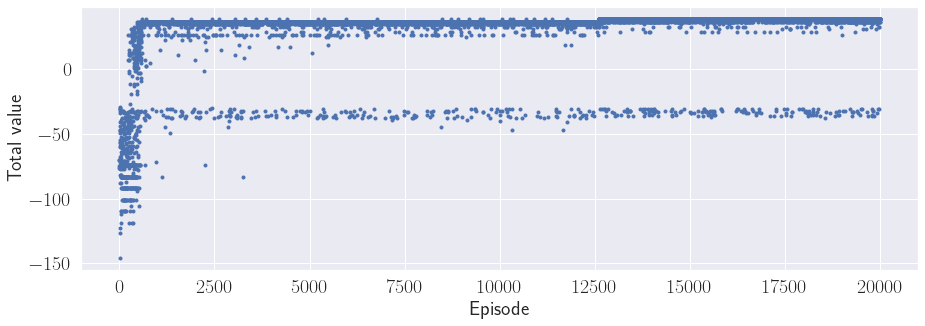

In [116]:
pyplot.figure(figsize=(15, 5))
pyplot.plot(range(1, 20000), q1_df["total value"], "b.")
pyplot.ylabel("Total value", fontsize=20)
pyplot.xlabel("Episode", fontsize=20)
pyplot.subplots_adjust(bottom=0.15)
pyplot.savefig("pick-up-training-speed-agent.png", dpi=300)

In [32]:
q1_df

,episode,total value,actions
0,1,-75,"[up, up, up, up, down, up, up, down, up, up, d..."
1,2,-70,"[down, up, right, up, up, up, up, down, down, ..."
2,3,-76,"[left, up, up, up, up, down, up, up, down, up,..."
3,4,-70,"[up, down, down, down, up, up, up, up, down, d..."
4,5,-29,"[right, down, up, up, down]"
...,...,...,...
19994,19995,39,"[right, right, right, up, right, left, left, u..."
19995,19996,39,"[right, right, right, up, right, left, left, u..."
19996,19997,39,"[right, right, right, up, right, left, left, u..."
19997,19998,39,"[right, right, right, up, right, left, left, u..."


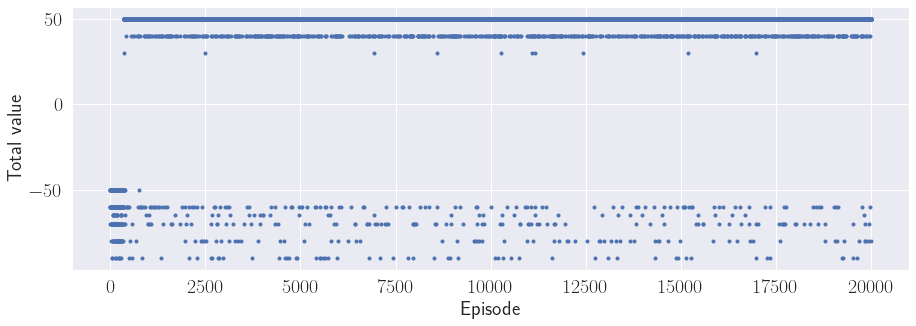

In [117]:
pyplot.figure(figsize=(15, 5))
pyplot.plot(range(1, 20000), q2_df["total value"], "b.")
pyplot.ylabel("Total value")
pyplot.xlabel("Episode")
pyplot.subplots_adjust(bottom=0.15)
pyplot.savefig("pick-up-training-safe-agent.png", dpi=300)

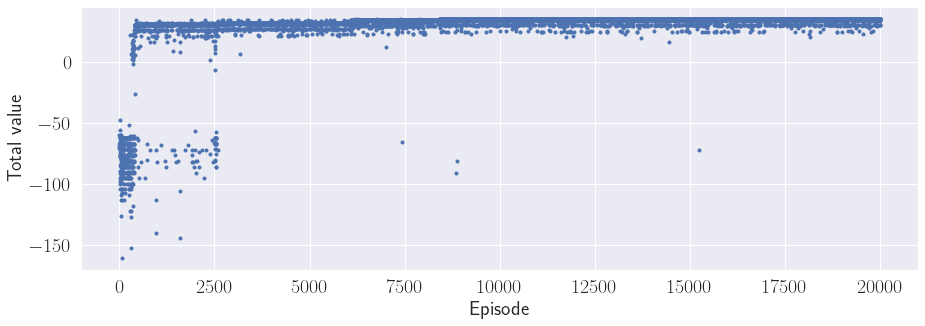

In [118]:
q3_df = episodes_to_df(q3_episodes)

pyplot.figure(figsize=(15, 5))
pyplot.plot(range(1, 20000), q3_df["total value"], "b.")
pyplot.ylabel("Total value", fontsize=20)
pyplot.xlabel("Episode", fontsize=20)
pyplot.subplots_adjust(bottom=0.15)
pyplot.savefig("pick-up-training-even-agent.png", dpi=300)

In [10]:
q2_df

,episode,total value,actions
0,1,-60,"[up, up, up, up, up, up, up, up, up, up, up, u..."
1,2,-50,"[up, up, down, up, down, up, down, up, down, u..."
2,3,-60,"[up, down, up, down, up, down, up, down, up, d..."
3,4,-60,"[up, down, up, down, up, down, up, down, up, d..."
4,5,-50,"[up, down, up, down, up, down, up, down, up, d..."
...,...,...,...
19994,19995,50,"[up, up, right, up, right, right, right, right..."
19995,19996,50,"[up, up, right, up, right, right, right, right..."
19996,19997,50,"[up, up, right, up, right, right, right, right..."
19997,19998,50,"[up, up, right, up, right, right, right, right..."


In [11]:
np.max(q2_df["total value"])

50

In [12]:
def create_state_value(
    q_table,
    height=6,
    width=7,
    weight_function=lambda x: x[0],
):
    state_values = list()
    for i in range(5):
        before_pickup = [0] * width * height
        after_pickup = [0] * width * height
        for ((position, damage, pickup), v) in q_table.items():
            if damage == i:
                if pickup == False:
                    before_pickup[position] = np.max(list(map(weight_function, v)))
                else:
                    after_pickup[position] = np.max(list(map(weight_function, v)))
        state_values.append((before_pickup, after_pickup))
    return state_values

In [13]:
state_values = create_state_value(q1.Q)
state_values[1][0]

[-1.543459535043608,
 -1.4207805983496782,
 -1.353055643144457,
 -1.0927663584310576,
 -0.6424866531389822,
 -0.378211071241,
 -0.28,
 -1.750981333060049,
 -1.7047491551101586,
 -1.5326083874441143,
 -0.9422497993848434,
 -0.2918374461874446,
 0.0,
 -0.1,
 -1.856524998884888,
 -1.0799684253419595,
 8.057858727639744,
 10.885972271339783,
 0.0,
 0,
 -0.1,
 -1.9900000000000002,
 7.164808394318187,
 10.920706405999894,
 13.245229339999891,
 0.0,
 -0.199,
 -0.20791,
 -2.0293146522724337,
 -2.071161273943184,
 -1.8640808398832962,
 8.527878750176612,
 12.365678167638846,
 -0.4274200000000001,
 -0.29701,
 -2.0288343621235896,
 -2.0923110469884207,
 -1.79269475578906,
 -1.3975757291704882,
 0,
 -0.27753984587719077,
 -0.2981124473588874]

In [14]:
import seaborn as sns
import matplotlib.cm as cm

sns.set(font_scale=1.4, rc={"text.usetex": True})
sns.set_theme()

/var/folders/dr/0vrw5h593pb67z126ltf52sh0000gn/T/ipykernel_3364/2469228555.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(cbar_ax.get_ymajorticklabels(), fontsize=20)
/var/folders/dr/0vrw5h593pb67z126ltf52sh0000gn/T/ipykernel_3364/2469228555.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])


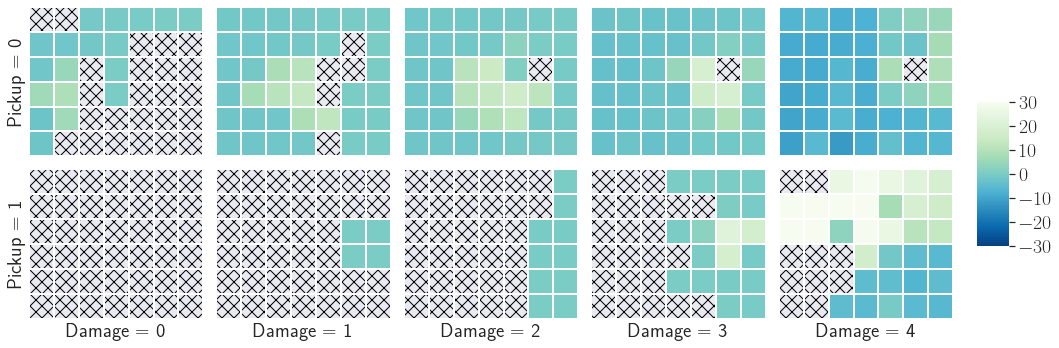

In [15]:
fig, axes = pyplot.subplots(2, 5, sharex="none", sharey="none", figsize=(15, 5))
# axes[-1, ].axis("off")
cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])
cbar_ax.set_yticklabels(cbar_ax.get_ymajorticklabels(), fontsize=20)
# char = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)", "(j)"]
for i, ax in enumerate(axes.flat):
    pickup = 0
    if i >= 5:
        pickup = 1
    arr = state_values[int(i % 5)][pickup]
    arr = np.reshape(arr, (6, 7))
    arr = np.ma.masked_equal(arr, 0)
    ax = sns.heatmap(
        arr,
        ax=ax,
        vmin=-30,
        vmax=30,
        center=0,
        cmap=cm.GnBu_r,  # sns.color_palette("rocket", as_cmap=True),
        linewidths=2,
        cbar=i == 0,
        mask=arr == 0,
        xticklabels=False,
        yticklabels=False,
        cbar_ax=None if i else cbar_ax,
    )

    if i % 5 == 0:
        ax.set_ylabel("Pickup = " + str(pickup), fontsize=20)
    if i >= 5:
        ax.set_xlabel(" Damage = " + str((i % 5)), fontsize=20)
    ax.patch.set(hatch="XX", edgecolor="black")
fig.tight_layout(rect=[0, 0, 0.9, 1])

pyplot.savefig("pick-up-and-deliver-speed-agent.png", dpi=300)

In [16]:
state_values_q2 = create_state_value(q2.Q, weight_function=lambda x: x[1])

/var/folders/dr/0vrw5h593pb67z126ltf52sh0000gn/T/ipykernel_3364/3657627525.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(cbar_ax.get_ymajorticklabels(), fontsize=20)
/var/folders/dr/0vrw5h593pb67z126ltf52sh0000gn/T/ipykernel_3364/3657627525.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])


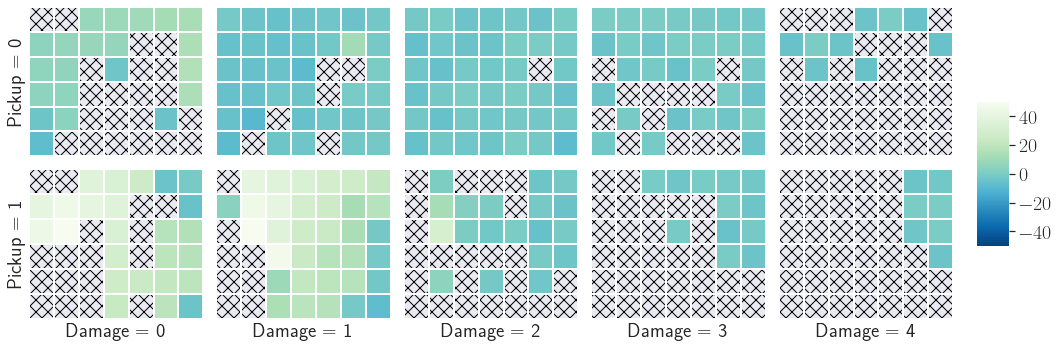

In [17]:
fig, axes = pyplot.subplots(2, 5, sharex="none", sharey="none", figsize=(15, 5))
# axes[-1, ].axis("off")
cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])
cbar_ax.set_yticklabels(cbar_ax.get_ymajorticklabels(), fontsize=20)
# char = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)", "(j)"]
for i, ax in enumerate(axes.flat):
    pickup = 0
    if i >= 5:
        pickup = 1
    arr = state_values_q2[int(i % 5)][pickup]
    arr = np.reshape(arr, (6, 7))
    arr = np.ma.masked_equal(arr, 0)
    ax = sns.heatmap(
        arr,
        ax=ax,
        vmin=-50,
        vmax=50,
        center=0,
        cmap=cm.GnBu_r,  # sns.color_palette("rocket", as_cmap=True),
        linewidths=2,
        cbar=i == 0,
        mask=arr == 0,
        xticklabels=False,
        yticklabels=False,
        cbar_ax=None if i else cbar_ax,
    )

    if i % 5 == 0:
        ax.set_ylabel("Pickup = " + str(pickup), fontsize=20)
    if i >= 5:
        ax.set_xlabel(" Damage = " + str((i % 5)), fontsize=20)
    ax.patch.set(hatch="XX", edgecolor="black")
fig.tight_layout(rect=[0, 0, 0.9, 1])

pyplot.savefig("pick-up-and-deliver-safety-agent.png", dpi=300)

In [18]:
def get_weight_function(alpha):
    return lambda x: ((1 - alpha) * x[0] + (alpha * (x[1])))

In [19]:
q1.explore_rate = 0
q1.learning_rate = 0
episodes = []
for alpha in range(0, 101, 1):
    alpha = alpha / 100
    totalValue = np.array([0, 0])
    world = env()
    q1.start_episode(world.current_state())
    q1._weight_function = get_weight_function(alpha)
    end = False
    while end != True:
        action = q1.act(world.current_state())
        value, end = world.act(action)
        totalValue = np.add(totalValue, value)

    q1.end_episode()
    episodes.append((alpha, totalValue))

In [20]:
episodes

[(0.0, array([39, 10])),
 (0.01, array([39, 10])),
 (0.02, array([39, 10])),
 (0.03, array([39, 10])),
 (0.04, array([39, 10])),
 (0.05, array([39, 10])),
 (0.06, array([39, 10])),
 (0.07, array([39, 10])),
 (0.08, array([39, 10])),
 (0.09, array([39, 10])),
 (0.1, array([39, 10])),
 (0.11, array([39, 10])),
 (0.12, array([39, 10])),
 (0.13, array([39, 10])),
 (0.14, array([39, 10])),
 (0.15, array([39, 10])),
 (0.16, array([39, 10])),
 (0.17, array([39, 10])),
 (0.18, array([39, 10])),
 (0.19, array([39, 10])),
 (0.2, array([39, 10])),
 (0.21, array([39, 10])),
 (0.22, array([39, 10])),
 (0.23, array([39, 10])),
 (0.24, array([39, 10])),
 (0.25, array([39, 10])),
 (0.26, array([39, 10])),
 (0.27, array([39, 10])),
 (0.28, array([39, 10])),
 (0.29, array([39, 10])),
 (0.3, array([39, 10])),
 (0.31, array([39, 10])),
 (0.32, array([39, 10])),
 (0.33, array([39, 10])),
 (0.34, array([39, 10])),
 (0.35, array([39, 10])),
 (0.36, array([-74, -50])),
 (0.37, array([-74, -50])),
 (0.38, arra

In [21]:
q2.explore_rate = 0
q2.learning_rate = 0
episodes_q2 = []
for alpha in range(100, -1, -1):
    alpha = alpha / 100
    totalValue = np.array([0, 0])
    world = env()
    q2.start_episode(world.current_state())
    q2._weight_function = get_weight_function(alpha)
    end = False
    while end != True:
        action = q2.act(world.current_state())
        value, end = world.act(action)
        totalValue = np.add(totalValue, value)
    q2.end_episode()
    episodes_q2.append((alpha, totalValue))

In [22]:
episodes_q2

[(1.0, array([29, 50])),
 (0.99, array([29, 50])),
 (0.98, array([29, 50])),
 (0.97, array([29, 50])),
 (0.96, array([29, 50])),
 (0.95, array([29, 50])),
 (0.94, array([29, 50])),
 (0.93, array([29, 50])),
 (0.92, array([29, 50])),
 (0.91, array([29, 50])),
 (0.9, array([29, 50])),
 (0.89, array([29, 50])),
 (0.88, array([29, 50])),
 (0.87, array([29, 50])),
 (0.86, array([29, 50])),
 (0.85, array([29, 50])),
 (0.84, array([29, 50])),
 (0.83, array([29, 50])),
 (0.82, array([29, 50])),
 (0.81, array([29, 50])),
 (0.8, array([29, 50])),
 (0.79, array([29, 50])),
 (0.78, array([29, 50])),
 (0.77, array([29, 50])),
 (0.76, array([29, 50])),
 (0.75, array([29, 50])),
 (0.74, array([33, 40])),
 (0.73, array([33, 40])),
 (0.72, array([33, 40])),
 (0.71, array([33, 40])),
 (0.7, array([33, 40])),
 (0.69, array([33, 40])),
 (0.68, array([33, 40])),
 (0.67, array([33, 40])),
 (0.66, array([33, 40])),
 (0.65, array([33, 40])),
 (0.64, array([33, 40])),
 (0.63, array([33, 40])),
 (0.62, array([3

In [23]:
state_values_q3 = create_state_value(q3.Q)

/var/folders/dr/0vrw5h593pb67z126ltf52sh0000gn/T/ipykernel_3364/3237190591.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(cbar_ax.get_ymajorticklabels(), fontsize=20)
/var/folders/dr/0vrw5h593pb67z126ltf52sh0000gn/T/ipykernel_3364/3237190591.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])


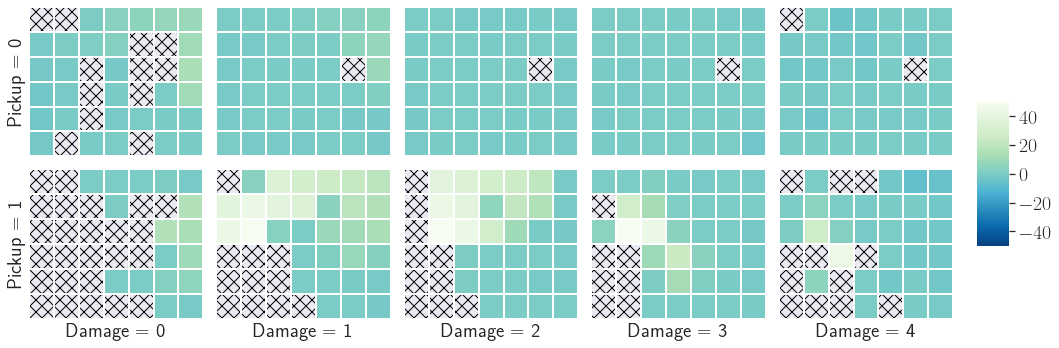

In [24]:
fig, axes = pyplot.subplots(2, 5, sharex="none", sharey="none", figsize=(15, 5))
# axes[-1, ].axis("off")
cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])
cbar_ax.set_yticklabels(cbar_ax.get_ymajorticklabels(), fontsize=20)
# char = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)", "(j)"]
for i, ax in enumerate(axes.flat):
    pickup = 0
    if i >= 5:
        pickup = 1
    arr = state_values_q3[int(i % 5)][pickup]
    arr = np.reshape(arr, (6, 7))
    arr = np.ma.masked_equal(arr, 0)
    ax = sns.heatmap(
        arr,
        ax=ax,
        vmin=-50,
        vmax=50,
        center=0,
        cmap=cm.GnBu_r,  # sns.color_palette("rocket", as_cmap=True),
        linewidths=2,
        cbar=i == 0,
        mask=arr == 0,
        xticklabels=False,
        yticklabels=False,
        cbar_ax=None if i else cbar_ax,
    )

    if i % 5 == 0:
        ax.set_ylabel("Pickup = " + str(pickup), fontsize=20)
    if i >= 5:
        ax.set_xlabel(" Damage = " + str((i % 5)), fontsize=20)
    ax.patch.set(hatch="XX", edgecolor="black")
fig.tight_layout(rect=[0, 0, 0.9, 1])

pyplot.savefig("pick-up-and-deliver-even-agent.png", dpi=300)

In [37]:
q3.explore_rate = 0
q3.learning_rate = 0
episodes_q3 = []
for alpha in range(0, 101, 1):
    alpha = alpha / 100
    totalValue = np.array([0, 0])
    world = env()
    q3.start_episode(world.current_state())
    q3._weight_function = get_weight_function(alpha)
    end = False
    while end != True:
        action = q3.act(world.current_state())
        value, end = world.act(action)
        totalValue = np.add(totalValue, value)
    q3.end_episode()
    episodes_q3.append((alpha, totalValue))

In [46]:
episodes_q3

[(0.0, array([-74, -90])),
 (0.01, array([-74, -90])),
 (0.02, array([-74, -90])),
 (0.03, array([-74, -90])),
 (0.04, array([-74, -90])),
 (0.05, array([-74, -90])),
 (0.06, array([-74, -90])),
 (0.07, array([-74, -90])),
 (0.08, array([-74, -90])),
 (0.09, array([-74, -90])),
 (0.1, array([-74, -90])),
 (0.11, array([-74, -90])),
 (0.12, array([-74, -50])),
 (0.13, array([31, 40])),
 (0.14, array([31, 40])),
 (0.15, array([31, 40])),
 (0.16, array([31, 40])),
 (0.17, array([31, 40])),
 (0.18, array([31, 40])),
 (0.19, array([31, 40])),
 (0.2, array([31, 40])),
 (0.21, array([31, 40])),
 (0.22, array([31, 40])),
 (0.23, array([31, 40])),
 (0.24, array([31, 40])),
 (0.25, array([31, 40])),
 (0.26, array([31, 40])),
 (0.27, array([31, 40])),
 (0.28, array([31, 40])),
 (0.29, array([31, 40])),
 (0.3, array([31, 40])),
 (0.31, array([31, 40])),
 (0.32, array([31, 40])),
 (0.33, array([31, 40])),
 (0.34, array([31, 40])),
 (0.35, array([31, 40])),
 (0.36, array([31, 40])),
 (0.37, array([3

In [67]:
q1_values = list(set(map(lambda x: tuple(x[1]), episodes)))
q2_values = list(set(map(lambda x: tuple(x[1]), episodes_q2)))
q3_values = list(set(map(lambda x: tuple(x[1]), episodes_q3)))

In [68]:
q2_values

[(31, 40), (-74, -90), (-31, -65), (33, 40), (29, 50), (-74, -50)]

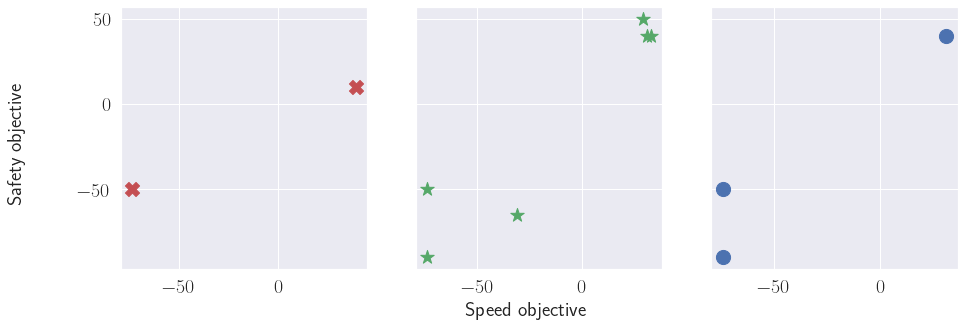

In [122]:
fig, axes = pyplot.subplots(1, 3, sharey=True, figsize=(15, 5))
fig.supxlabel("Speed objective", fontsize=20)
fig.supylabel("Safety objective", fontsize=20)
axes[0].scatter(*zip(*q1_values), marker="X", c="r", s=200, label="$A_1$")
axes[1].scatter(*zip(*q2_values), marker="*", c="g", s=200, label="$A_2$")
axes[2].scatter(*zip(*q3_values), marker="o", c="b", s=200, label="$A_2$")
ax.legend()
pyplot.subplots_adjust(bottom=0.15)
pyplot.savefig("pick-up-pareto.png", dpi=300)